---
format:
  html:
    code-fold: false
---

## Thermo-mechanical coupling

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
from jax import Array
import jax.numpy as jnp


import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

Lets start with creating a mesh for a unit square domain.

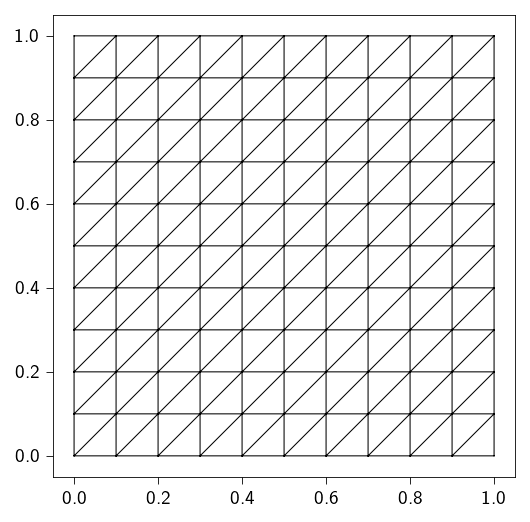

In [ ]:
mesh = Mesh.unit_square(10, 10)

n_nodes = mesh.coords.shape[0]
n_elasticity_dofs_per_node = 2
n_diffusion_dofs_per_node = 1

n_dofs_per_node = n_elasticity_dofs_per_node + n_diffusion_dofs_per_node
n_elasticity_dofs = n_elasticity_dofs_per_node * n_nodes
n_diffusion_dofs = n_diffusion_dofs_per_node * n_nodes
n_total_dofs = n_elasticity_dofs + n_diffusion_dofs

plt.style.use(STYLE_PATH)
plt.figure(figsize=(4, 4))
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

### Thermo-mechanical coupling

For a domain $\Omega$ with thermal conductivity $k$ and an internal source $Q$ (heat per unit volume per unit time), the equation is:

$$
\nabla \cdot (k \nabla T) + Q = 0 \quad \text{in } \Omega
$$

The thermal functional to be minimized is:

$$
\Pi_\text{d}(c) = \int_{\Omega} \left( \frac{1}{2} D (\nabla c \cdot \nabla c) - Q c \right) dV - \int_{\Gamma_q} \bar{q} c \, dA
$$

In [73]:
elasticity_dofs =  jnp.arange(n_elasticity_dofs)
diffusion_dofs =  jnp.arange(n_elasticity_dofs, n_elasticity_dofs + n_diffusion_dofs)

## Defining the constitutive model

$$
\psi_\text{d} = \frac{1}{2} D (\nabla c \cdot \nabla c) - Q.c
$$



In [71]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient
    D: float  # Diffusion coefficient


mat = Material(mu=1.0, lmbda=1.0, D=1.0)

In [74]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2, c_quad=0, mu=0, lmbda=0)
def compute_stress(eps: Array, c_quad: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    kappa = 1.0
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I - kappa * c_quad * I


@auto_vmap(grad_u=2, c_quad=0, mu=0, lmbda=0)
def strain_energy(grad_u: Array, c_quad: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, c_quad, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


In [ ]:
@auto_vmap(c=0, grad_c=1, D=0)
def diffusion_potential(c: Array, grad_c: Array, D: Array) -> Array:
    return 0.5 * D * (grad_c @ grad_c)



In [ ]:

@op.integrate
def total_diffusion_energy(c: Array, grad_c: Array, *_) -> Array:
    diffusion_potential = diffusion_potential(c, grad_c, mat.D)
    return diffusion_potential


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, c_quad: Array) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, c_quad, mat.mu, mat.lmbda)

In [76]:
@jax.jit
def total_energy(u_flat):
    u_elasticity = u_flat.at[:n_elasticity_dofs].get()
    u_diffusion = u_flat.at[n_elasticity_dofs:].get()
    u_elasticity = u_elasticity.reshape(-1, n_elasticity_dofs_per_node)
    
    u_diffusion_quad = op.eval(u_diffusion).squeeze()

    elasticity_energy = total_strain_energy(u_elasticity, u_diffusion_quad)
    diffusion_energy = total_diffusion_energy(u_diffusion)

    return elasticity_energy + diffusion_energy

In [72]:
tri = element.Tri3()
op = Operator(mesh, tri)

line = element.Line2()
op_line = Operator(mesh, line)

In [77]:
u = jnp.zeros(n_total_dofs)

In [78]:
total_energy(u)

Array(0., dtype=float64)

In [79]:
gradient = jax.jacrev(total_energy)
hessian = jax.jacfwd(gradient)

In [80]:
K_coupled = hessian(u)

In [81]:
n_total_dofs

363

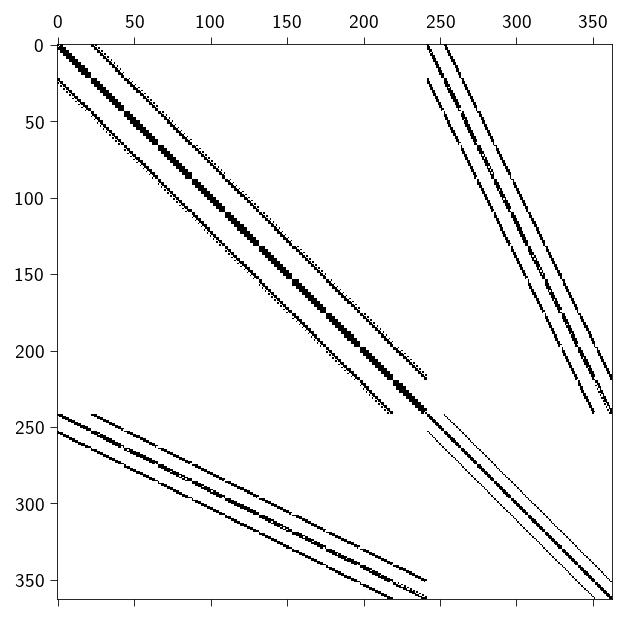

In [82]:
plt.spy(K_coupled)
plt.show()

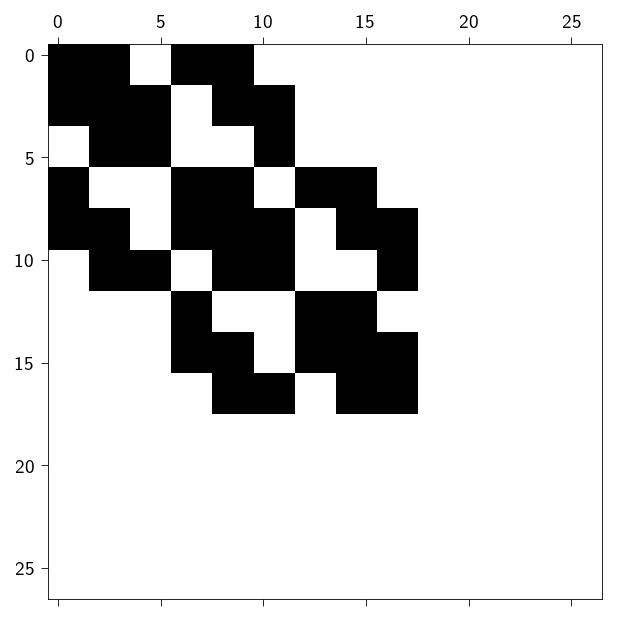

In [69]:
sparsity_pattern = femsolver.sparse.create_sparsity_pattern(
    mesh.elements, n_dofs_per_node=2, K_shape=(n_total_dofs, n_total_dofs)
)

plt.spy(sparsity_pattern.todense())
plt.show()

In [27]:
import sparsejac

In [28]:
hessian_sparse = sparsejac.jacfwd(gradient, sparsity=sparsity_pattern)

In [29]:
Kd_sparse = hessian_sparse(c)

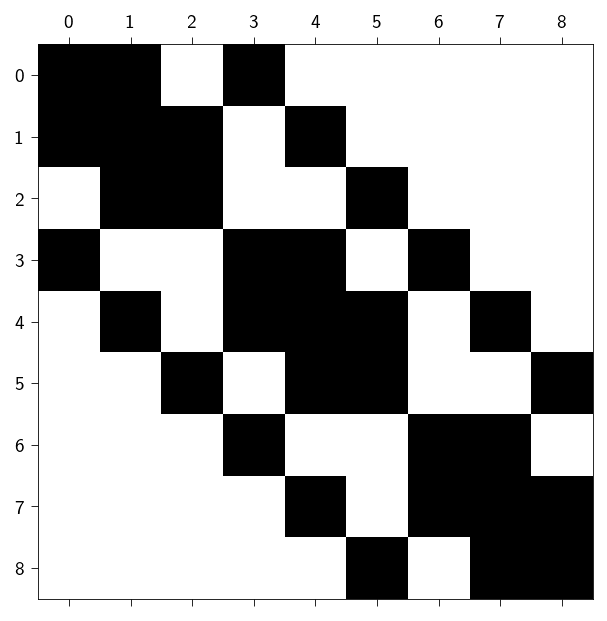

In [30]:
plt.spy(Kd_sparse.todense())
plt.show()